<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/updata_cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/2/uc?id=13IHwu22RjH9h3lPfvVvoix8l4f4NpfE5&export=download&confirm=t'
output = "cat_and_dog.zip"
gdown.download(url, output)

file_path = "cat_and_dog.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/2/uc?id=13IHwu22RjH9h3lPfvVvoix8l4f4NpfE5&export=download&confirm=t
To: /content/cat_and_dog.zip
100%|██████████| 143M/143M [00:00<00:00, 194MB/s]


In [7]:
!pip install efficientnet_pytorch
!pip install lime

In [8]:
from trainer import *
from utils_tool import *
import torch
from efficientnet_pytorch import EfficientNet
from transform import *
import torch.optim as optim
from loss_fn import *
import numpy as np
import random

In [9]:
learning_rate = 0.001
batch_size = 40
num_workers = 0
epochs = 300
train_path = 'dataset/train/'
test_path = 'dataset/test/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds, test_ds, id_to_class = get_dataloader(train_path,test_path,batch_size,num_workers)

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b2').to(device)
num_feature = model._fc.in_features
model._fc = nn.Linear(num_feature, 2).to(device)
model.fc = nn.Linear(num_feature, 2).to(device)

model = load_checkpoint(model,path='checkpoint/ckpt_0.pth')
#optimizer = optim.SGD(params=model.parameters(),lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(params = model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2
==> Resuming from checkpoint..


In [11]:
train = trainer(train_ds, test_ds, model, optimizer, scheduler, criterion, epochs=epochs)
train.vaild_scaler_epoch(0)

Epoch 1: 100%|██████████| 75/75 [00:35<00:00,  2.12it/s, loss=0.00158]


Epoch : 1, Val_loss : 0.09797704964876175, Acc : 0.9886666666666667


In [12]:
class_to_id = {v: k for k, v in id_to_class.items()}
image_path_id = test_ds_path(test_path, class_to_id)
print(class_to_id)

{'cat': 0, 'dog': 1}


In [13]:
from tqdm import tqdm
from PIL import Image
import cv2
model.eval()
transform = get_test_transforms()
correct = 0
for idx, (img_path, lab) in enumerate(tqdm(image_path_id)):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[np.newaxis,:,:,:].to(device)
    out = model(img)
    predicted = int(torch.argmax(out, 1))
    if predicted == lab:
        correct += 1
    image_path_id[idx] = [img_path, lab, predicted]
print('\n',correct/len(image_path_id))

100%|██████████| 3000/3000 [01:40<00:00, 29.91it/s]


 0.9886666666666667


In [14]:
total_lab_class = [0,0]
total_pred_class = [0,0]
for idx, (img_p, lab, pred) in enumerate(image_path_id):
    total_lab_class[lab] = total_lab_class[lab] + 1
    if lab == pred:
        total_pred_class[pred] = total_pred_class[pred] + 1
accuracy = [p / l for p, l in zip(total_pred_class, total_lab_class)]
print(accuracy)
    

[0.9913333333333333, 0.986]


In [15]:
each_class_pred_info = {0:{0:[],1:[]}, 1:{0:[],1:[]}}
for idx, info in enumerate(image_path_id):
    each_class_pred_info[info[1]][info[2]].append(info)

for k in each_class_pred_info.keys():
    info = each_class_pred_info[k]
    print(id_to_class[k], ' predict as:')
    print()
    total = 0
    for n in info.keys():
        print('%-16s' % id_to_class[n], ':', end='')
        print(len(info[n]),end='')
        if n == k:
            print('  correct!', end='')
        print()
        total += len(info[n])
    print('total:', total, ' Accuracy:', accuracy[k])
    print()

cat  predict as:

cat              :1487  correct!
dog              :13
total: 1500  Accuracy: 0.9913333333333333

dog  predict as:

cat              :21
dog              :1479  correct!
total: 1500  Accuracy: 0.986



In [27]:
def get_image(class_name, pred_name, dic=class_to_id):
    class_id = class_to_id[class_name]
    pred_id = class_to_id[pred_name]
    data_list = each_class_pred_info[class_id][pred_id]
    if data_list==[]:
        return 'No image' , class_name, pred_name
    image_info = random.choice(data_list)
    image = np.array(Image.open(image_info[0]).convert('RGB'))
    return image, class_name, pred_name
  
def batch_predict(images, model=model, transform=get_test_transforms()):
    model.eval()
    batch = torch.stack(tuple(transform(Image.fromarray(i)) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)

    return probs.detach().cpu().numpy()

cat dog


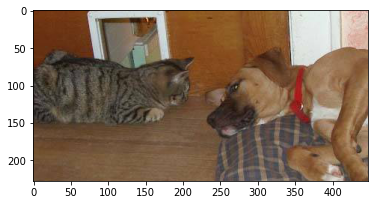

In [28]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
image, class_name, pred_class = get_image('cat','dog')
print(class_name,pred_class)
plt.imshow(image)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

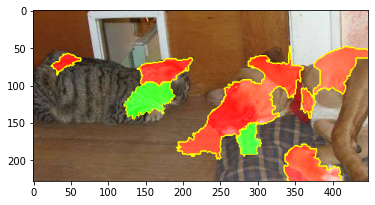

In [36]:
#num_features最有可能是label的前幾個
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(image, batch_predict, top_labels=2, hide_color=0,num_samples=1000)
temp, mask = exp.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

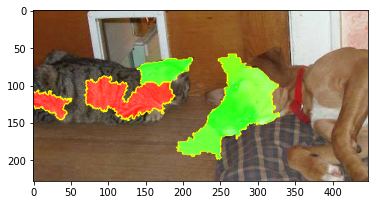

In [37]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(image, batch_predict, top_labels=2, hide_color=0,num_samples=1000)
temp, mask = exp.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

cat cat


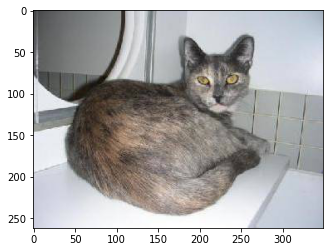

In [38]:
image, class_name, pred_class = get_image('cat','cat')
print(class_name,pred_class)
plt.imshow(image)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

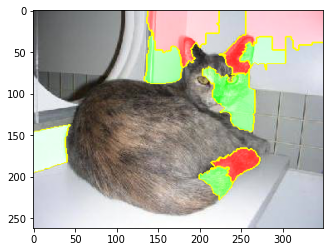

In [39]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(image, batch_predict, top_labels=2, hide_color=0,num_samples=1000)
temp, mask = exp.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

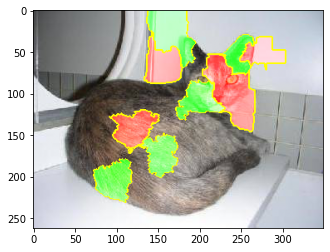

In [40]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(image, batch_predict, top_labels=2, hide_color=0,num_samples=1000)
temp, mask = exp.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)